# Testing TF-ENFORMER

In [1]:
import json, os, sys, h5py, subprocess, tqdm
# import parsl
# from parsl.app.app import python_app
# from parsl.providers import LocalProvider
# from parsl.executors import HighThroughputExecutor
# from parsl.channels import LocalChannel
# from parsl.config import Config
import pandas as pd
import numpy as np
import importlib
from functools import lru_cache

In [1]:
#@lru_cache(1)
def add2(a=2, b=3):
    return a+b

In [5]:
def sub2(a, b):
    print(b)
    return(a - b)

In [8]:
sub2(20, b=add2)

<function add2 at 0x7fdae8653520>


TypeError: unsupported operand type(s) for -: 'int' and 'function'

In [28]:
add2.cache_clear()
res = []
for i in range(0, 20):
    print(add2.cache_info())
    res.append(add2())

CacheInfo(hits=0, misses=0, maxsize=1, currsize=0)
CacheInfo(hits=0, misses=1, maxsize=1, currsize=1)
CacheInfo(hits=1, misses=1, maxsize=1, currsize=1)
CacheInfo(hits=2, misses=1, maxsize=1, currsize=1)
CacheInfo(hits=3, misses=1, maxsize=1, currsize=1)
CacheInfo(hits=4, misses=1, maxsize=1, currsize=1)
CacheInfo(hits=5, misses=1, maxsize=1, currsize=1)
CacheInfo(hits=6, misses=1, maxsize=1, currsize=1)
CacheInfo(hits=7, misses=1, maxsize=1, currsize=1)
CacheInfo(hits=8, misses=1, maxsize=1, currsize=1)
CacheInfo(hits=9, misses=1, maxsize=1, currsize=1)
CacheInfo(hits=10, misses=1, maxsize=1, currsize=1)
CacheInfo(hits=11, misses=1, maxsize=1, currsize=1)
CacheInfo(hits=12, misses=1, maxsize=1, currsize=1)
CacheInfo(hits=13, misses=1, maxsize=1, currsize=1)
CacheInfo(hits=14, misses=1, maxsize=1, currsize=1)
CacheInfo(hits=15, misses=1, maxsize=1, currsize=1)
CacheInfo(hits=16, misses=1, maxsize=1, currsize=1)
CacheInfo(hits=17, misses=1, maxsize=1, currsize=1)
CacheInfo(hits=18, miss

In [18]:
res = [add2(i, j) for i in range(0, 10) for j in range(11, 21)]

In [21]:
add2.cache_info()

CacheInfo(hits=0, misses=125, maxsize=8, currsize=8)

In [2]:
def peek(iterable):
    import itertools
    try:
        first = next(iterable)
    except StopIteration:
        return None

    return itertools.chain([first], iterable)

In [32]:
def calculate(i):
    return i + (i/2)
gen_list = (calculate(i) for i in range(0, 20))

In [33]:
peek(gen_list), list(gen_list)

In [2]:
script_path = '.'
sys.path.append(f'{script_path}/utilities')

import runPredictionUtilities
import enformerUsageCodes

# this helps reload the modules incase changes were made
importlib.reload(enformerUsageCodes)
importlib.reload(runPredictionUtilities)

2022-11-18 02:35:41.700154: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /soft/perftools/darshan/darshan-3.3.0/lib:/opt/cray/pe/papi/6.0.0.1/lib64:/opt/cray/job/2.2.4-7.0.2.1_2.91__g36b56f4.ari/lib64:/opt/intel/compilers_and_libraries_2020.0.166/linux/compiler/lib/intel64:/opt/intel/compilers_and_libraries_2020.0.166/linux/compiler/lib/intel64_lin:/opt/intel/compilers_and_libraries_2020.0.166/linux/mpi/intel64/lib:/opt/intel/compilers_and_libraries_2020.0.166/linux/mpi/mic/lib:/opt/intel/compilers_and_libraries_2020.0.166/linux/ipp/lib/intel64:/opt/intel/compilers_and_libraries_2020.0.166/linux/compiler/lib/intel64:/opt/intel/compilers_and_libraries_2020.0.166/linux/mkl/lib/intel64:/opt/intel/compilers_and_libraries_2020.0.166/linux/tbb/lib/intel64/gcc4.4:/opt/intel/debugger_2020/libipt/intel64/lib:/opt/intel/comp

<module 'runPredictionUtilities' from '/lus/theta-fs0/projects/covid-ct/imlab/users/temi/projects/TFXcan/enformer-predict/scripts-2/./utilities/runPredictionUtilities.py'>

In [16]:
parsl.clear()


# usage_codes = f'{script_path}/enformer-usage-codes.py'
# #parsl_config = f'{script_path}/parsl-configuration.py'
# personal_enformer = f'{script_path}/personal-enformer.py'

# # import the enformer-usage_codes.py file
# exec(open(usage_codes).read(), globals(), globals())
# exec(open(personal_enformer).read(), globals(), globals())

rundir = '/projects/covid-ct/imlab/users/temi/projects/running-parsl/runinfo'
workingdir = '/projects/covid-ct/imlab/users/temi/projects/running-parsl'

local_htex = Config(
    executors=[
        HighThroughputExecutor(
            label="htex_Local",
            worker_debug=True,
            cores_per_worker=1,
            working_dir=workingdir,
            provider=LocalProvider(
                channel=LocalChannel(),
                init_blocks=1,
                max_blocks=1,
            ),
        )
    ],
    strategy=None,
    run_dir=rundir
)

parsl.load(local_htex)

In [3]:
# read the parameters file
with open(f'{script_path}/../metadata/enformer_parameters.json') as f:

    parameters = json.load(f)

    intervals_dir = parameters['interval_list_dir']
    model_path = parameters['model_path']
    fasta_file = parameters['hg38_fasta_file']
    output_dir = parameters['output_dir']
    individuals = parameters['individuals']
    vcf_file = parameters['vcf_file']
    path_to_bcftools = parameters['path_to_bcftools']
    path_to_tabix = parameters['path_to_tabix']
    temporary_vcf_dir = parameters['temporary_vcf_dir']
    TF = parameters['TF']
    logfile_path = parameters['logfile_path']

In [2]:
def generate_batch(lst, batch_size):
    """  Yields batch of specified size """
    if batch_size <= 0:
       return
    for i in range(0, len(lst), batch_size):
        yield lst[i:(i + batch_size)]

In [5]:
lst = range(0, 97)
mybatch = generate_batch(lst, 10)
for batch in mybatch:
    print(batch)

In [4]:
logfile_path = "/projects/covid-ct/imlab/users/temi/projects/TFXcan/enformer-predict/predictions-log"
sam = 'LuCaP_70' #'LuCaP_167' #LuCaP_208' #'LuCaP_145'
#queries = ['chr2_186155022_186155031', 'chr6_137209238_137209247', 'chr3_185586974_185586983']

In [5]:
fasta_object = enformerUsageCodes.FastaStringExtractor(fasta_file)
fasta_object

In [6]:
def get_fastaExtractor(fasta_file_path=fasta_file, script_path=script_path):

    import sys
    sys.path.append(f'{script_path}/utilities')
    import enformerUsageCodes
    # usageCodes = f'{script_path}/utilities/enformerUsageCodes.py'
    # exec(open(usageCodes).read(), globals(), globals()) 

    fasta_extractor = enformerUsageCodes.FastaStringExtractor(fasta_file_path)
    return fasta_extractor

In [6]:
query_list = ['chr1_103268936_103268945', 'chr1_150333985_150333994', 'chr12_45119102_45119111', 'chr8_146200116_146200125']

In [63]:
a = pd.read_table(f'{intervals_dir}/{sam}_{TF}_400000.txt', sep=' ', header=None)
list_of_regions = a[0].tolist()[0:101]

In [66]:
len(list_of_regions)

101

In [14]:
import pyfaidx

In [67]:
sequence_dict = {}
error_dict = {}
for each_region in tqdm.tqdm(list_of_regions):
    a = runPredictionUtilities.create_region_file(vcf_file=vcf_file, region=each_region, subset_vcf_dir=temporary_vcf_dir, individual=sam, software_paths=[path_to_bcftools, path_to_tabix])
    b = runPredictionUtilities.extract_individual_sequence(subset_dict=a, fasta_file_path=fasta_file, fasta_func=get_fastaExtractor, script_path=script_path, delete_region=True)
    sequence_dict[each_region] = b
    # except pyfaidx.FetchError as err:
    #     error_dict[each_region] = b

 66%|██████▋   | 67/101 [00:42<00:50,  1.48s/it]

[ERROR] (from pyfaidx) FetchError for chr6_170681267_170681276 of type <class 'ValueError'>


100%|██████████| 101/101 [01:00<00:00,  1.67it/s]


In [29]:
sequence_dict['chr3_185057_185066']

{'sequence': None, 'sequence_source': None, 'region': 'chr3_185057_185066'}

In [15]:
ll = [len(x) for x in sequence_list]
ll

[393216, 393216, 393216, 1258093]

In [43]:
def check_query(sample, query, output_dir, logfile):
    '''
    Checks of predictions are available for an individual or sample
    '''
    import pandas as pd
    import os

    if isinstance(logfile, type(None)):
        return(query)

    elif isinstance(logfile, pd.DataFrame):# should have read it>
        motif_in_logfile = logfile.motif.values
        individual_in_logfile = logfile.individual.values
        query_saved = str(f'{output_dir}/{sample}/{query}_predictions.h5')

        # four conditions 
        a = (query in motif_in_logfile)
  
        b = (sample in individual_in_logfile)
       

        if (logfile.motif.empty) | (logfile.individual.empty):
            c = False
        elif logfile.loc[(logfile.motif==query) & (logfile.individual==sample)].empty == True:
            c = False
        else:
            c = (logfile.loc[(logfile.motif==query) & (logfile.individual==sample), 'status'].values[0] == 'completed')
        

        d = os.path.isfile(query_saved)

        if not (a and b and c and d):
            return(query)

In [6]:
if not os.path.exists(f'{output_dir}/{sam}'):
    print(f'\n[CREATING OUTPUT DIRECTORY] at {output_dir}/{sam}')
    os.makedirs(f'{output_dir}/{sam}')

if not os.path.exists(f'{sequence_folder}/{sam}'):
    print(f'\n[CREATING SEQUENCE FOLDER] at {sequence_folder}/{sam}')
    os.makedirs(f'{sequence_folder}/{sam}')

In [12]:
isinstance(logfile, pd.DataFrame)

True

In [13]:
logfile_path

'/projects/covid-ct/imlab/users/temi/projects/TFXcan/enformer-predict/predictions-log'

In [35]:
logfile_csv = f'{logfile_path}/{sam}_predictions_log.csv'
if os.path.isfile(logfile_csv):
    logfile = pd.read_csv(logfile_csv)
    open_mode = 'a'
else:
    logfile = None
    open_mode = 'w'

logfile

,motif,individual,status,sequence_type
0,chr2_41161413_41161422,LuCaP_208,completed,var
1,chr14_75226962_75226971,LuCaP_208,completed,var
2,chr3_190159061_190159070,LuCaP_208,completed,var
3,chr19_18867730_18867739,LuCaP_208,completed,var
4,chr2_158031004_158031013,LuCaP_208,completed,var
5,chr9_69944183_69944192,LuCaP_208,completed,var


In [76]:
query_list[0] in logfile.motif.values

True

In [24]:
query_list = ['chr1_103268936_103268945', 'chr1_150333985_150333994', 'chr12_45119102_45119111', 'chr8_146200116_146200125']

In [44]:
gen_list = [check_query(sample='LuCaP_208', query="chr8_30280640_30280649", output_dir='../../enformer-predictions/freedman/matched-predictions', logfile=logfile) for q in query_list]
#filtered_gen_list = (l for l in gen_list if not isinstance(l, type(None)))

False
True
False
False
True
False
False
True
False


In [50]:
query="chr9_69944183_69944192"#"chr8_30280640_30280649"
sample='LuCaP_208'
logfile.loc[(logfile.motif==query) & (logfile.individual==sample), 'status'].values[0]

'completed'

In [20]:
list(filtered_gen_list)

['chr1_150333985_150333994']

In [17]:
next(filtered_gen_list)

StopIteration: 

In [33]:
peek(filtered_gen_list)

In [28]:
list(j)

[]

In [71]:
list(gen_list)

['chr1_103268936_103268945',
 'chr1_150333985_150333994',
 'chr12_45119102_45119111']

In [8]:
fasta_object = enformerUsageCodes.FastaStringExtractor(fasta_file)
fasta_object

In [8]:
dt = pd.read_table('../../motif-intervals/freedman/predictors/LuCaP_173_FOXA1_400000.txt', header=None)[0].tolist()
dt_start = [int(d.split('_')[1]) for d in dt]
dt_start[1:5]


[111057330, 77601761, 28507991, 57827317]

In [13]:
0 in dt_start

False

In [9]:
query_status = []
for i, query in enumerate(queries):
    query_status.append(runPredictionUtilities.check_query(sample=sam, query=query, output_dir=output_dir, logfile=logfile))
# evaluate the results >> this should return a list of those that don't have predictions

In [10]:
q_status = [q for q in query_status]
print(f'Query results are: {q_status} ======\n')

Query results are: ['chr2_186155022_186155031', 'chr6_137209238_137209247', 'chr3_185586974_185586983'] ======



In [23]:
reg_split = q_status[0].split('_')
region = [reg_split[0], int(reg_split[1]), int(reg_split[2]), q_status[0]]
region

['chr2', 186155022, 186155031, 'chr2_186155022_186155031']

In [22]:
sequence_list = []
for each_region in q_status:
    a = runPredictionUtilities.create_region_file(vcf_file=vcf_file, region=each_region, subset_vcf_dir=temporary_vcf_dir, individual=sam, software_paths=[path_to_bcftools, path_to_tabix])
    b = runPredictionUtilities.extract_individual_sequence(subset_dict=a, fasta_file_path=fasta_file, fasta_extractor=fasta_object, delete_region=False)
    sequence_list.append(b['sequence'][sam])

#fasta_object.close()

In [23]:
sys.getsizeof(sequence_list)
b['sequence'][sam]
#parsl.clear()

88

In [19]:
sequence_encoded = runPredictionUtilities.one_hot_encode(b['sequence'][sam])

In [20]:
sys.getsizeof(sequence_encoded)

6291584

In [24]:
import os

In [29]:
people = ['_'.join(o.split('_')[0:2]) for o in os.listdir('../../motif-intervals/freedman/predictors/')]
people

['LuCaP_173',
 'LuCaP_167',
 'LuCaP_93',
 'LuCaP_81',
 'LuCaP_70',
 'LuCaP_189',
 'LuCaP_78',
 'LuCaP_208',
 'LuCaP_86',
 'LuCaP_141',
 'LuCaP_58',
 'LuCaP_77',
 'LuCaP_170',
 'LuCaP_145',
 'LuCaP_49',
 'LuCaP_136',
 'LuCaP_92']

In [31]:
with open('../../enformer-predict/metadata/individuals.txt', 'w') as f:
    f.write('\n'.join(people))

In [9]:
sys.getsizeof(sequences[0])

NameError: name 'sequences' is not defined

In [10]:
print(sequences[0]) #['sequence'][sam][0:5])

NameError: name 'sequences' is not defined

In [11]:
enf_model = tf.saved_model.load(model_path).model

2022-11-10 16:05:21.306909: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-11-10 16:05:21.306980: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (thetalogin5): /proc/driver/nvidia/version does not exist
2022-11-10 16:05:21.309736: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
@bash_app
def call_single_enformer_run(call_script, sequence_region, sam, stderr='./bashapp_error.err'):
    return(' '.join(['bash', call_script, sequence_region, sam]))

In [17]:
call_script = f"{script_path}/single-enformer-bashapp.sh"

In [18]:
out = [call_single_enformer_run(call_script=call_script, sequence_region=sreg, sam=sam) for sreg in q_status]

In [19]:
out

[<AppFuture at 0x7f649ec63fa0 state=pending>,
 <AppFuture at 0x7f649ec62f50 state=pending>,
 <AppFuture at 0x7f649ec63bb0 state=pending>]

In [20]:
out_finished = [o.result() for o in out]

In [21]:
out_finished

[0, 0, 0]

### Using parsl with a generator vs a list

In [34]:
import parsl
import time

import os, sys
from parsl.app.app import python_app, bash_app
from parsl.config import Config
from parsl.providers import CobaltProvider, LocalProvider
from parsl.launchers import MpiExecLauncher, AprunLauncher, SingleNodeLauncher
from parsl.executors import HighThroughputExecutor, ThreadPoolExecutor
from parsl.channels import LocalChannel
from parsl.configs.local_threads import config
from parsl.data_provider.files import File

In [38]:
# just in case there is a config file
parsl.clear()

# I defined these locations otherwise parsl will use the current directory to output the run informations and log messages
rundir = '/projects/covid-ct/imlab/users/temi/projects/running-parsl/runinfo'
workingdir = '/projects/covid-ct/imlab/users/temi/projects/running-parsl'

local_tpex = Config(
    executors=[
        ThreadPoolExecutor(
            label="tpex_Local",
            max_threads=24, # using 24 threads
            working_dir=workingdir
        )
    ],
    strategy=None,
    run_dir=rundir # where should outputs or errors be logged e.t.c.
)

parsl.load(local_tpex)

In [39]:
@python_app
def process_number(i):
    return(i + (1/i))

In [53]:
# using a list comprehension

tic = time.process_time()
lc_futures = [process_number(j) for j in range(1, 5000)]
lc_results = [p.result() for p in lc_futures]

print(f'Using a list comprehension: {time.process_time() - tic}')

Using a list comprehension: 4.504831471000003


In [50]:
# using a generator
tic = time.process_time()
gen_futures = (process_number(j) for j in range(1, 5000))
gen_results = (p.result() for p in gen_futures)
gen_results = list(gen_results)

print(f'Using a generator: {time.process_time() - tic}')

Using a generator: 4.335732449999995


In [54]:
parsl.clear()

## Querying vcf files

In [14]:
import cyvcf2, kipoiseq
import matplotlib.pyplot as plt
import time, tqdm

In [8]:
samples = ['LuCaP_173', 'LuCaP_145', 'LuCaP_70']

In [9]:
myvcf = cyvcf2.cyvcf2.VCF(vcf_file, samples=samples[0])

In [77]:
callable(myvcf)

False

In [78]:
def make_cyvcf_object(vcf_file, sample):
    import cyvcf2
    return(cyvcf2.cyvcf2.VCF(vcf_file, samples=sample))

In [81]:
import types
isinstance(myvcf, types.FunctionType)

False

In [86]:
type(myvcf) == cyvcf2.cyvcf2.VCF

True

In [82]:
callable(myvcf), callable(make_cyvcf_object)

(True, True)

In [73]:
myvcf.samples

['LuCaP_173']

In [25]:
def extract_reference_sequence(region, fasta_object, resize_for_enformer=True, resize_length=None):
    import kipoiseq

    SEQUENCE_LENGTH = 393216

    region_split = region.split('_')
    region_chr = region_split[0]
    region_start = int(region_split[1])
    region_end = int(region_split[2])

    if resize_for_enformer == True:
        reg_interval = kipoiseq.Interval(region_chr, region_start, region_end).resize(SEQUENCE_LENGTH)
    else:
        reg_interval = kipoiseq.Interval(region_chr, region_start, region_end).resize(resize_length)

    # extract the sequence 
    ref_sequences = fasta_object.extract(interval=reg_interval, anchor=[])
    return({'sequences': ref_sequences, 'interval_object': reg_interval})
    
def find_variants_in_vcf_file(cyvcf2_object, interval_object):

    '''
    Find variants for a region in a vcf file
    Returns an empty string if no variant is present
    
    '''
    query = f'{interval_object.chrom}:{interval_object.start}-{interval_object.end}'
    return([[variant.CHROM, variant.POS, variant.genotypes[0][0:2], variant.gt_bases[0].split('|')] for variant in cyvcf2_object(query)])

def create_mapping_dictionary(variants_array, interval_start, haplotype='hap1'):
    if haplotype == 'hap1':
        haplotype_map = {(variants_array[i][1] - interval_start): variants_array[i][3][0] for i in range(0, len(variants_array)) if variants_array[i][2][0] == 1}
        return(haplotype_map)
        #return({(k - interval_start): v for k, v in haplotype_map.items() if v is not None})
    elif haplotype == 'hap2':
        haplotype_map = {(variants_array[i][1] - interval_start): variants_array[i][3][1] for i in range(0, len(variants_array)) if variants_array[i][2][1] == 1}
        return(haplotype_map)
    elif haplotype == 'both':
        haplotype_map = {variants_array[i][1]: variants_array[i][3][0] if variants_array[i][2][0] == 1 else variants_array[i][3][1] if variants_array[i][2][1] == 1 else None for i in range(0, len(variants_array))}
        haplotype_map = {(k - interval_start): v for k, v in haplotype_map.items() if v is not None}
        return(haplotype_map)

def replace_variants_in_reference_sequence(query_sequences, mapping_dict):

    sequence_list = list(query_sequences)
    a = map(lambda i: mapping_dict.get(i, sequence_list[i]), range(len(sequence_list)))
    return(''.join(list(a)))


def find_nucleotide_by_position_within_sequence(sequence, qpos, interval_start):
    if qpos < interval_start:
        print('Query position cannot be less than the start of the interval')
    else:
        return(sequence[qpos - interval_start])

In [76]:
def create_individual_input_for_enformer(region, vcf_object, fasta_object, sample=None,hap_type = 'hap1', resize_for_enformer=True, resize_length=None):

    import types

    if (isinstance(vcf_object, types.FunctionType)) and (type(vcf_object) != cyvcf2.cyvcf2.VCF): # not a string
        vcf_object = vcf_object()
    elif isinstance(vcf_object, type('a')): # or a path to a vcf file
        import cyvcf2
        vcf_object = cyvcf2.cyvcf2.VCF(vcf_object, samples=sample)
    elif callable(vcf_object) and (type(vcf_object) == cyvcf2.cyvcf2.VCF):
        pass

    a = extract_reference_sequence(region, fasta_object, resize_for_enformer)

    # check that all the sequences in a are valid
    if all(i == 'N' for i in a['sequences']):
        print(f'[ERROR] {region} is invalid; all nucleotides are N.')
        return(None)
    else:
        b = find_variants_in_vcf_file(vcf_object, a['interval_object'])

        if b: # go on and change the variants by position
            c = create_mapping_dictionary(b, a['interval_object'].start, haplotype=hap_type)
            variant_sequence = replace_variants_in_reference_sequence(a['sequences'], c)
            return({'sequence':variant_sequence, 'sequence_source':'var', 'region':region})
        else: # return the reference
            return({'sequence': a['sequences'], 'sequence_source':'ref', 'region':region})

In [12]:
query_list = ['chr1:103268936-103268945', 'chr1:150333985-150333994', 'chr12:45119102-45119111', 'chr8:146200116-146200125']
query_list = ['chr1_103268936_103268945', 'chr1_150333985_150333994', 'chr12_45119102_45119111', 'chr8_146200116_146200125']

To understand what I have to do, not the following

In [32]:
resize_length = 10

In [ ]:
fasta_object.extract

In [ ]:
103072672

In [59]:
some_interval

Interval(chrom='chr8', start=146200116, end=146200125, name='', strand='.', ...)

In [72]:
some_interval = kipoiseq.Interval('chr8', 145138000, 145138010).resize(None)
fasta_object.extract(some_interval)

'NNNNNNNNNN'

In [62]:
some_interval = kipoiseq.Interval('chr1', 103074410, 103074416).resize(None)
fasta_object.extract(some_interval)

'CAGGCG'

In [39]:
q_reg = 'chr1_103072673_103072674'
extract_reference_sequence(q_reg, fasta_object, resize_for_enformer=False, resize_length=None)

{'sequences': 'G',
 'interval_object': Interval(chrom='chr1', start=103072673, end=103072674, name='', strand='.', ...)}

The sequences are the same, but the start and end coordinates differ based on the sequences
- when extracting from the fasta obje

In [55]:
hap_type = 'both'

tic = time.process_time()
output = create_individual_input_for_enformer(region=query_list[3], vcf_object=myvcf, fasta_object=fasta_object, hap_type = 'hap1', resize_for_enformer=True, resize_length=None)
assert type(output) == type('a')
time.process_time() - tic

0.001535724000000016

In [ ]:
output

In [48]:
tic = time.process_time()
output = create_individual_input_for_enformer(region=query_list[0], vcf_object=myvcf, fasta_object=fasta_object, hap_type = 'hap1', resize_for_enformer=True, resize_length=None)
assert type(output) == type('a')
assert len(output) == 393216
time.process_time() - tic

0.08431086799999932

In [15]:
# is using 'hap1'
try: 
    assert c[103076704] == 'G'
except KeyError as ke:
    print('Perhaps a KeyError for 103076704')

assert c[103076724] == 'T'
assert c[103076932] == 'G'
assert c[103077001] == 'G'
print('Everything else is expected.')

Perhaps a KeyError for 103076704


KeyError: 103076724

In [16]:
# is using both 
assert c[103076704] == 'G'
assert c[103076724] == 'T'
assert c[103076932] == 'G'
assert c[103077001] == 'G'
print('Everything else is expected.')

KeyError: 103076704

In [17]:
if hap_type == 'both':
    old_qnuc = find_nucleotide_by_position_within_sequence(a['sequences'], 103076724, a['interval_object'].start)
    new_qnuc = find_nucleotide_by_position_within_sequence(new_func_result, 103076724, a['interval_object'].start)

    assert old_qnuc == 'C'
    assert new_qnuc == 'T'

AssertionError: 

In [298]:
old_qnuc

'A'

In [18]:
{(a['interval_object'].start + k):v for k, v in c.items()}

{103074425: 'G',
 103076704: 'G',
 103076724: 'T',
 103076932: 'G',
 103077001: 'G',
 103077721: 'A',
 103079371: 'C',
 103079628: 'G',
 103079717: 'A',
 103080398: 'A',
 103081960: 'T',
 103082763: 'G',
 103082941: 'C',
 103083226: 'C',
 103083694: 'C',
 103084306: 'A',
 103085338: 'T',
 103085773: 'T',
 103085794: 'C',
 103085921: 'C',
 103085922: 'C',
 103085942: 'G',
 103086325: 'A',
 103086362: 'A',
 103086490: 'A',
 103086536: 'T',
 103086565: 'T',
 103086967: 'A',
 103087259: 'T',
 103087364: 'G',
 103087379: 'G',
 103087451: 'A',
 103087714: 'A',
 103088208: 'C',
 103088474: 'A',
 103088737: 'T',
 103089907: 'T',
 103092607: 'A',
 103094611: 'G',
 103094834: 'G',
 103096707: 'T',
 103097078: 'G',
 103097312: 'G',
 103097546: 'T',
 103098885: 'T',
 103100913: 'A',
 103102309: 'A',
 103103171: 'T',
 103106195: 'T',
 103106807: 'G',
 103107371: 'G',
 103107991: 'A',
 103110798: 'T',
 103111304: 'C',
 103111402: 'T',
 103111889: 'G',
 103112778: 'A',
 103113273: 'A',
 103113274: 'C

In [47]:
#b

In [148]:
len(d) == 393216

True

Using the modules I defined earlier

In [48]:
def get_fastaExtractor(fasta_file_path=fasta_file, script_path=script_path):

    # import sys
    # sys.path.append(f'{script_path}/utilities')
    # import enformerUsageCodes
    usageCodes = f'{script_path}/utilities/enformerUsageCodes.py'
    exec(open(usageCodes).read(), globals(), globals()) 

    fasta_extractor = FastaStringExtractor(fasta_file_path)
    return fasta_extractor

In [50]:
import time

In [60]:
tic = time.process_time()
reg_file = runPredictionUtilities.create_region_file(vcf_file=vcf_file, region=query_list[0], subset_vcf_dir=temporary_vcf_dir, individual=samples[0], software_paths=[path_to_bcftools, path_to_tabix])
old_func_result = runPredictionUtilities.extract_individual_sequence(subset_dict=reg_file, fasta_file_path=fasta_file, fasta_func=get_fastaExtractor, script_path=script_path, delete_region=False)

time.process_time() - tic

0.046188381000000334

In [79]:
import time, tqdm
import matplotlib.pyplot as plt

In [104]:
time_new_func = []

for t in tqdm.tqdm(range(0, 101)):
    tic = time.perf_counter()
    a = extract_reference_sequence(query_list[1], fasta_object, resize_for_enformer=True)
    b = find_variants_in_vcf_file(myvcf, a['interval_object'])
    c = create_mapping_dictionary(b, a['interval_object'].start, haplotype=hap_type)
    new_func_result = replace_variants_in_reference_sequence(a['sequences'], c)

    time_new_func.append(time.perf_counter() - tic)

100%|██████████| 101/101 [00:09<00:00, 11.08it/s]


In [103]:
np.mean(time_new_func)

0.08810286689549685

In [105]:
time_old_func = []
for t in tqdm.tqdm(range(0, 101)):
    tic = time.perf_counter()
    reg_file = runPredictionUtilities.create_region_file(vcf_file=vcf_file, region=query_list[1], subset_vcf_dir=temporary_vcf_dir, individual=samples[0], software_paths=[path_to_bcftools, path_to_tabix])
    old_func_result = runPredictionUtilities.extract_individual_sequence(subset_dict=reg_file, fasta_file_path=fasta_file, fasta_func=get_fastaExtractor, script_path=script_path, delete_region=True)

    time_old_func.append(time.perf_counter() - tic)


100%|██████████| 101/101 [00:37<00:00,  2.69it/s]


In [101]:
np.mean(time_old_func)

0.5050085228867829

In [120]:
log_old_time = -np.log10(time_old_func)
log_new_time = -np.log10(time_new_func)

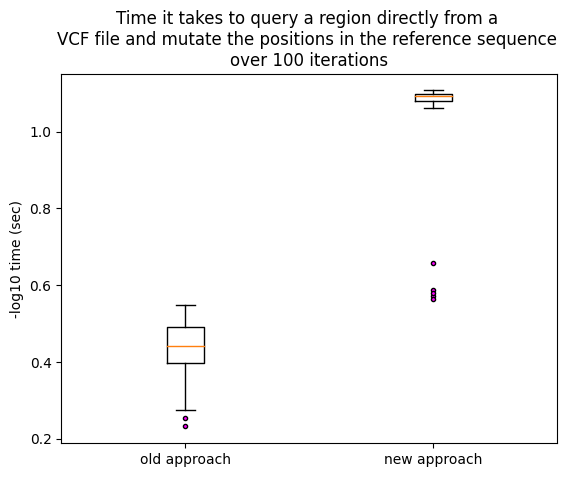

In [121]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.boxplot([log_old_time, log_new_time], flierprops={'marker': 'o', 'markersize': 3, 'markerfacecolor': 'fuchsia'})

ax.set_title('Time it takes to query a region directly from a \nVCF file and mutate the positions in the reference sequence \nover 100 iterations')
ax.set_ylabel('-log10 time (sec)')

plt.xticks([1, 2], ['old approach', 'new approach'])

plt.show()

In [289]:
find_nucleotide_by_position_within_sequence(old_func_result['sequence'], 103074425, reg_file['interval'].start)

'C'

In [292]:
find_nucleotide_by_position_within_sequence(new_func_result, 103076724, a['interval_object'].start)

'T'

In [239]:
a['interval_object'].start == reg_file['interval'].start

True

In [215]:
old_func_result['sequence'] == new_func_result, len(old_func_result['sequence']) == len(new_func_result) == 393216

(False, True)

In [216]:
[i for i in range(len(old_func_result['sequence'])) if old_func_result['sequence'][i] != new_func_result[i]]

[2091,
 4370,
 4390,
 4598,
 4667,
 5387,
 7037,
 7294,
 7383,
 8064,
 9626,
 10429,
 10607,
 10892,
 11360,
 11972,
 13004,
 13439,
 13460,
 13587,
 13588,
 13608,
 13991,
 14028,
 14156,
 14202,
 14231,
 14633,
 14925,
 15030,
 15045,
 15117,
 15380,
 15874,
 16140,
 16403,
 17573,
 20273,
 22277,
 22500,
 24373,
 24744,
 24978,
 25212,
 26551,
 28579,
 29975,
 30837,
 33861,
 34473,
 35037,
 35657,
 38464,
 38970,
 39068,
 39555,
 40444,
 40939,
 40940,
 41008,
 41896,
 43071,
 44311,
 46504,
 47646,
 48162,
 49522,
 49828,
 53575,
 55303,
 56324,
 61018,
 62767,
 66379,
 67426,
 74179,
 75464,
 75466,
 81747,
 81765,
 84216,
 85765,
 87336,
 88311,
 91558,
 92190,
 92690,
 95717,
 97034,
 97311,
 98426,
 98438,
 98443,
 98470,
 98478,
 98484,
 98486,
 98489,
 99293,
 106497,
 108343,
 108959,
 111507,
 115547,
 117008,
 117356,
 119054,
 119103,
 119640,
 120760,
 120973,
 121034,
 122222,
 124013,
 125224,
 125788,
 127603,
 128107,
 128892,
 129680,
 132628,
 133943,
 134936,
 13

In [177]:
b

[['chr1', 103072672, [0, 0], ['T', 'T']],
 ['chr1', 103073435, [0, 0], ['A', 'A']],
 ['chr1', 103073451, [0, 0], ['A', 'A']],
 ['chr1', 103074415, [0, 0], ['C', 'C']],
 ['chr1', 103074421, [0, 0], ['G', 'G']],
 ['chr1', 103074425, [1, 1], ['G', 'G']],
 ['chr1', 103074933, [0, 0], ['A', 'A']],
 ['chr1', 103075330, [0, 0], ['C', 'C']],
 ['chr1', 103075338, [0, 0], ['A', 'A']],
 ['chr1', 103075375, [0, 0], ['T', 'T']],
 ['chr1', 103075378, [0, 0], ['T', 'T']],
 ['chr1', 103075381, [0, 0], ['A', 'A']],
 ['chr1', 103075394, [0, 0], ['G', 'G']],
 ['chr1', 103075428, [0, 0], ['T', 'T']],
 ['chr1', 103075436, [0, 0], ['T', 'T']],
 ['chr1', 103075438, [0, 0], ['T', 'T']],
 ['chr1', 103075455, [0, 0], ['A', 'A']],
 ['chr1', 103075458, [0, 0], ['T', 'T']],
 ['chr1', 103075464, [0, 0], ['A', 'A']],
 ['chr1', 103075474, [0, 0], ['G', 'G']],
 ['chr1', 103075477, [0, 0], ['A', 'A']],
 ['chr1', 103075480, [0, 0], ['A', 'A']],
 ['chr1', 103075483, [0, 0], ['C', 'C']],
 ['chr1', 103075484, [0, 0], ['T',

In [132]:
b_map = create_mapping_dict(b, a['interval_object'])

103072333


In [264]:
temp_seq = 'AGTGCCGATAAGGGCCT'
changes = {5:'X', 9:'Y', 11:'Z', 15:'W'} # 5 corresponding to pos 487, 491 and 493 and 497respectively
int_start = 482
new_seq = replace_variants_in_reference_sequence(temp_seq, changes)
assert new_seq == 'AGTGCXGATYAZGGCWT', 'Something is wrong'

In [266]:
qpos = 497
find_position_within_reference_sequence(temp_seq, qpos, int_start), find_position_within_reference_sequence(new_seq, qpos, int_start)

('C', 'W')

In [98]:
a = map(lambda i: changes.get(i, tt_seq[i]), range(len(tt_seq)))
''.join(list(a))

'AGTACCGATAX'

In [90]:
''.join(tt_seq)

'AGTACCGATAA'

In [56]:
query_output = []
for variant in myvcf('chr1:120000-3000000'):
    a = [variant.CHROM, variant.POS, variant.genotypes[0][0:2], variant.gt_bases[0].split('|')]
    query_output.append(a)
print(type(query_output))

<class 'list'>


### How to log files

In [1]:
import logging

In [2]:
logdir = '../cobalt-log'

In [5]:


MEMORY_LOG_FILE = f"{logdir}/memory_usage.log"
CACHE_LOG_FILE = f"{logdir}/cache_usage.log"

def main():

    setup_logger('memory_log', MEMORY_LOG_FILE)
    setup_logger('cache_log', CACHE_LOG_FILE)

    logger('Logging out to log one...', 'info', 'memory')
    logger('Logging out to log two...', 'warning', 'cache')

def setup_logger(logger_name, log_file, level=logging.INFO):

    log_setup = logging.getLogger(logger_name)
    formatter = logging.Formatter('[%(levelname)s: %(asctime)s] %(message)s', datefmt='%m/%d/%Y %I:%M:%S %p')
    fileHandler = logging.FileHandler(log_file, mode='a')
    fileHandler.setFormatter(formatter)
    streamHandler = logging.StreamHandler()
    streamHandler.setFormatter(formatter)
    log_setup.setLevel(level)
    log_setup.addHandler(fileHandler)
    log_setup.addHandler(streamHandler)

def logger(msg, level, logfile):
 
    if logfile == 'memory'   : log = logging.getLogger('memory_log')
    if logfile == 'cache'   : log = logging.getLogger('cache_log') 
    if level == 'info'    : log.info(msg) 
    if level == 'warning' : log.warning(msg)
    if level == 'error'   : log.error(msg)

In [6]:
main()

[INFO: 11/24/2022 03:16:51 PM] Logging out to log one...
[INFO: 11/24/2022 03:16:51 PM] Logging out to log one...
[WARNING: 11/24/2022 03:16:51 PM] Logging out to log two...
[WARNING: 11/24/2022 03:16:51 PM] Logging out to log two...


### Check nvidia memory

In [7]:
import subprocess as sp
import os

def get_gpu_memory():
    command = "nvidia-smi --query-gpu=memory.free --format=csv"
    memory_free_info = sp.check_output(command.split()).decode('ascii').split('\n')[:-1][1:]
    memory_free_values = [int(x.split()[0]) for i, x in enumerate(memory_free_info)]
    return memory_free_values

get_gpu_memory()

CalledProcessError: Command '['nvidia-smi', '--query-gpu=memory.free', '--format=csv']' returned non-zero exit status 9.

### Formatting cache log files

In [1]:
import os, re

In [38]:
file = '../cobalt-log/cache_usage.log'

In [39]:
with open(file, 'r') as cf:
    j = cf.readlines()
    cache_list = [i.strip('\n') for i in j]

In [40]:
len(cache_list)

30468

In [41]:
cache_list[0]

'[INFO: 11/25/2022 12:30:40 PM] [CACHE INFO] (fasta) CacheInfo(hits=0, misses=1, maxsize=5, currsize=1) on thetagpu14'

In [42]:
cache_model = [j for j in cache_list if re.search('model', j) is not None]
#cache_model = [c for c in cache_model if c is not None]
cache_model

['[INFO: 11/25/2022 12:30:52 PM] [CACHE INFO] (model) CacheInfo(hits=0, misses=1, maxsize=5, currsize=1) on thetagpu14',
 '[INFO: 11/25/2022 12:30:52 PM] [CACHE INFO] (model) CacheInfo(hits=0, misses=1, maxsize=5, currsize=1) on thetagpu14',
 '[INFO: 11/25/2022 12:30:52 PM] [CACHE INFO] (model) CacheInfo(hits=0, misses=1, maxsize=5, currsize=1) on thetagpu14',
 '[INFO: 11/25/2022 12:30:52 PM] [CACHE INFO] (model) CacheInfo(hits=0, misses=1, maxsize=5, currsize=1) on thetagpu14',
 '[INFO: 11/25/2022 12:30:52 PM] [CACHE INFO] (model) CacheInfo(hits=0, misses=1, maxsize=5, currsize=1) on thetagpu14',
 '[INFO: 11/25/2022 12:30:52 PM] [CACHE INFO] (model) CacheInfo(hits=0, misses=1, maxsize=5, currsize=1) on thetagpu14',
 '[INFO: 11/25/2022 12:30:52 PM] [CACHE INFO] (model) CacheInfo(hits=0, misses=1, maxsize=5, currsize=1) on thetagpu14',
 '[INFO: 11/25/2022 12:30:52 PM] [CACHE INFO] (model) CacheInfo(hits=0, misses=1, maxsize=5, currsize=1) on thetagpu14',
 '[INFO: 11/25/2022 12:30:52 PM]

In [57]:
reg_query = r"^\[INFO:.*\(model\)[\sa-zA-Z0-9]*\(([\w\d\W]{1,})\).*on.*(theta.*)"
cache_model_results = [re.search(reg_query, j).groups() for j in cache_model]

#re.search(r"^\[INFO:.*\(fasta\)[\sa-zA-Z0-9]*(\([\w\d\W]{1,}\))", 

In [58]:
cache_model_results

[('hits=0, misses=1, maxsize=5, currsize=1', 'thetagpu14'),
 ('hits=0, misses=1, maxsize=5, currsize=1', 'thetagpu14'),
 ('hits=0, misses=1, maxsize=5, currsize=1', 'thetagpu14'),
 ('hits=0, misses=1, maxsize=5, currsize=1', 'thetagpu14'),
 ('hits=0, misses=1, maxsize=5, currsize=1', 'thetagpu14'),
 ('hits=0, misses=1, maxsize=5, currsize=1', 'thetagpu14'),
 ('hits=0, misses=1, maxsize=5, currsize=1', 'thetagpu14'),
 ('hits=0, misses=1, maxsize=5, currsize=1', 'thetagpu14'),
 ('hits=0, misses=1, maxsize=5, currsize=1', 'thetagpu14'),
 ('hits=0, misses=1, maxsize=5, currsize=1', 'thetagpu14'),
 ('hits=0, misses=1, maxsize=5, currsize=1', 'thetagpu14'),
 ('hits=0, misses=1, maxsize=5, currsize=1', 'thetagpu14'),
 ('hits=0, misses=1, maxsize=5, currsize=1', 'thetagpu14'),
 ('hits=0, misses=1, maxsize=5, currsize=1', 'thetagpu14'),
 ('hits=0, misses=1, maxsize=5, currsize=1', 'thetagpu14'),
 ('hits=0, misses=1, maxsize=5, currsize=1', 'thetagpu14'),
 ('hits=1, misses=1, maxsize=5, currsize

In [15]:
def make_cache_dict(g):

    g = g.split(', ')
    g = [h.split('=') for h in g]
    return {l[0]:int(l[1]) for l in g}


In [53]:
cache_model_dict = [make_cache_dict(g) for g in cache_model_results]

In [55]:
cache_model_dict

[{'hits': 0, 'misses': 1, 'maxsize': 5, 'currsize': 1},
 {'hits': 0, 'misses': 1, 'maxsize': 5, 'currsize': 1},
 {'hits': 0, 'misses': 1, 'maxsize': 5, 'currsize': 1},
 {'hits': 0, 'misses': 1, 'maxsize': 5, 'currsize': 1},
 {'hits': 0, 'misses': 1, 'maxsize': 5, 'currsize': 1},
 {'hits': 0, 'misses': 1, 'maxsize': 5, 'currsize': 1},
 {'hits': 0, 'misses': 1, 'maxsize': 5, 'currsize': 1},
 {'hits': 0, 'misses': 1, 'maxsize': 5, 'currsize': 1},
 {'hits': 0, 'misses': 1, 'maxsize': 5, 'currsize': 1},
 {'hits': 0, 'misses': 1, 'maxsize': 5, 'currsize': 1},
 {'hits': 0, 'misses': 1, 'maxsize': 5, 'currsize': 1},
 {'hits': 0, 'misses': 1, 'maxsize': 5, 'currsize': 1},
 {'hits': 0, 'misses': 1, 'maxsize': 5, 'currsize': 1},
 {'hits': 0, 'misses': 1, 'maxsize': 5, 'currsize': 1},
 {'hits': 0, 'misses': 1, 'maxsize': 5, 'currsize': 1},
 {'hits': 0, 'misses': 1, 'maxsize': 5, 'currsize': 1},
 {'hits': 1, 'misses': 1, 'maxsize': 5, 'currsize': 1},
 {'hits': 1, 'misses': 1, 'maxsize': 5, 'currsiz

In [54]:
hits = [d['hits'] for d in cache_model_dict]
hits[0:4]

[0, 0, 0, 0]

In [44]:
reg_query = r"^\[INFO:.*\(model\)[\sa-zA-Z0-9]*\(([\w\d\W]{1,})\).*on.*(theta.*)"


<re.Match object; span=(0, 116), match='[INFO: 11/25/2022 12:30:52 PM] [CACHE INFO] (mode>

In [50]:
re.search(reg_query, cache_model[0]).groups()

('hits=0, misses=1, maxsize=5, currsize=1', 'thetagpu14')

In [31]:
misses = [d['misses'] for d in cache_model_dict]
misses[0:4]

[1, 1, 1, 1]

In [14]:
cache_model_results[0]

'hits=0, misses=1, maxsize=5, currsize=1'

In [34]:
g = g.split(', ')
g = [h.split('=') for h in g]
{l[0]:int(l[1]) for l in g}

{'hits': 0, 'misses': 1, 'maxsize': 5, 'currsize': 1}

In [26]:
import matplotlib.pyplot as plt
import subprocess

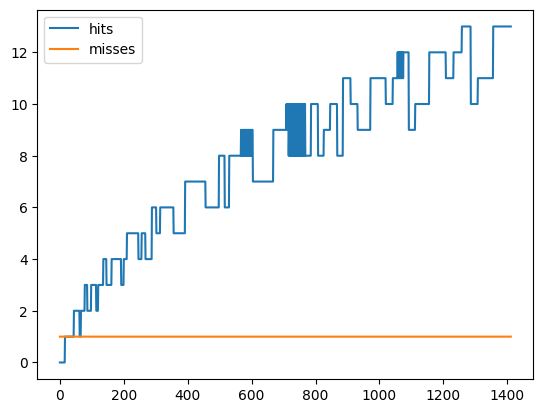

In [37]:
plt.plot(hits, label='hits')
plt.plot(misses, label='misses')
plt.legend()
plt.show()

In [ ]:
import subprocess

In [25]:
cmd = "cat $COBALT_NODEFILE"
str(subprocess.run(cmd, shell=True, capture_output=True).stdout, encoding='utf-8').strip('\n')

b'\n'

In [ ]:
cmd = "nvidia-smi --query-gpu=gpu_bus_id --format=csv"
str(subprocess.run(cmd, shell=True, capture_output=True).stdout, encoding='utf-8').strip('\n')

In [ ]:
cmd = "nvidia-smi -L"
str(subprocess.run(cmd, shell=True, capture_output=True).stdout, encoding='utf-8').strip('\n')